In [86]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

First I wanted to test the model without direct connections (W = 0)

In [112]:
# dataset that contains most popoular polish surnames
words = open('polish_surnames.txt', 'r', encoding='utf-16').read().splitlines()
print(len(words))
words[:5]

47972


['NOWAK', 'KOWALSKI', 'WIŚNIEWSKI', 'WÓJCIK', 'KOWALCZYK']

In [113]:
# mappings from string elements (chars really) to ints

# all possible characters (vocab)
chars = sorted(list(set(''.join(words))))
v = len(chars) + 1 # vocab size

# mappings
stoi = { ch:i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i:ch for ch, i in stoi.items()}

print(f'vocab_size = {v}')

vocab_size = 68


In [102]:
# function that builds the dataset with apropriate block_size
def build_dataset(data, block_size):
    X, Y = [], []
    for word in data:
        context = [0] * block_size
        for ch in word + '.':
            index = stoi[ch]
            X.append(context)
            Y.append(index)
            context = context[1:] + [index]

    X, Y = torch.tensor(X), torch.tensor(Y)
    return X, Y

In [338]:
# hyperparameters
block_size = 3
m = 50  # number of dimenstions
h = 100 # number of hidden units
learning_rate = 0.1
n_iter = 100000
batch_size = 32

In [14]:
X, Y = build_dataset(words, block_size)

print(X.shape, Y.shape)
for x,y in zip(X[:10], Y[:10]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

torch.Size([412553, 12]) torch.Size([412553])
............ --> N
...........N --> O
..........NO --> W
.........NOW --> A
........NOWA --> K
.......NOWAK --> .
............ --> K
...........K --> O
..........KO --> W
.........KOW --> A


In [340]:
# create random splits of data - 90% train set, 10% validation set
import random # for reproducibility
random.seed(42)
random.shuffle(words)

n = int(0.9 * Y.shape[0])
X_train, X_val = X[:n], X[n:]
Y_train, Y_val = Y[:n], Y[n:]

In [341]:
# parameters
g = torch.Generator().manual_seed(42) # for reproducibility

C = torch.randn((v, m), generator=g)
H = torch.randn((m * block_size, h), generator=g)
d = torch.randn(h, generator=g)
U = torch.randn((h, v), generator=g)
b = torch.randn(v, generator=g)

parameters = [C, H, d, U, b]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True  

25368


In [342]:
steps = []
step_loss = []

for iter in range(n_iter):
   # getting minibatch
    index = torch.randint(0, X_train.shape[0], (batch_size,)) 

    # forward pass
    x = C[X_train[index]].view(-1, m * block_size)
    hidden_layer = torch.tanh(x @ H + d)
    logits = hidden_layer @ U + b
    loss = F.cross_entropy(logits, Y_train[index])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # save data
    steps.append(iter)
    step_loss.append(loss.log10())

    learning_rate = 0.1 if iter < 50000 else 0.01
            
    # update    
    for p in parameters:
        p.data -= learning_rate * p.grad

    # print once in a while
    if (iter+1) % 1000 == 0:
        print(iter+1, loss.item())

1000 3.5210044384002686
2000 3.262807846069336
3000 3.6174895763397217
4000 2.926891326904297


KeyboardInterrupt: 

In [343]:
# plotting average logged loss every 500 data points 
plt.plot(torch.tensor(step_loss).view(-1, 500).mean(1))

RuntimeError: shape '[-1, 500]' is invalid for input of size 4062

In [344]:
# calculate losses on the splits
def get_loss(split):
    if split == 'train':
        X_split, Y_split = X_train, Y_train 
    else:
        X_split, Y_split = X_val, Y_val
    x = C[X_split].view(-1, m * block_size)          
    hidden_layer = torch.tanh(x @ H + d)
    logits = hidden_layer @ U + b    
    loss = F.cross_entropy(logits, Y_split)
    return loss.item()

l = get_loss('train')
print(f'train_loss = {l}')
l = get_loss('val')
print(f'val_loss = {l}')

train_loss = 2.6934778690338135
val_loss = 2.8799991607666016


##### Playing with hyperparameters
v = 68 (vocab size)
| block_size | m (dims) | h (n_hidden) | learning_rate* | n_iter | batch_size | train_loss | val_loss | total params|
|:---:|:---:|:---:|:--------:|:---:|:---:|:--------:|:--------:|:---:|
| 3 | 20 | 100 | 0.1 | 100000 | 32 | 2.0255532264709473 | 2.1562182903289795 | 14328 |
| **3** | **20** | **100** | **0.1 / 0.01** | **100000** | **32** | **1.9864557981491089** | **2.1179306507110596** | **14328** |
| 3 | 50 | 100 | 0.1 | 100000 | 32 | 2.020906686782837 | 2.1610190868377686 | 25368 |
| **3** | **50** | **100** | **0.1 / 0.01** | **100000** | **32** | **1.976877212524414** | **2.11557936668396** | **25368** |
| 5 | 50 | 100 | 0.1 | 100000 | 32 | 2.0558860301971436 | 2.179558515548706 | 35368 |
| 5 | 50 | 100 | 0.1 / 0.01 | 100000 | 32 | 2.054567575454712 | 2.1728193759918213 | 35368 |
| 8 | 50 | 100 | 0.1 | 100000 | 32 | 2.244689702987671 | 2.353611707687378 | 50368 |
| 8 | 50 | 100 | 0.1 / 0.01 | 100000 | 32 | 2.174644947052002 | 2.279350757598877 | 50368 |
| 8 | 50 | 100 | 0.1 / 0.01 | 200000 | 32 | 2.297348737716675 | 2.421205759048462 | 50368 |
| 8 | 50 | 100 | 0.1 / 0.01 | 200000 | 64 | 2.2630765438079834 | 2.3948867321014404 | 50368 |
| 12 | 50 | 100 | 0.1 / 0.01 | 200000 | 64 | 2.387294054031372 | 2.4829165935516357 | 70368 |
| 12 | 50 | 200 | 0.1 / 0.01 | 200000 | 64 | 2.36772084236145 | 2.4919257164001465 | 137268 |
| 12 | 50 | 200 | 0.1 | 100000 | 64 | 2.267059564590454 | 2.387253522872925 | 137268 | 137268 |
| 12 | 50 | 200 | 0.1 / 0.01 | 100000 | 64 | 2.220881938934326 | 2.344449043273926 | 137268 |
| 12 | 50 | 400 | 0.1 / 0.01 | 100000 | 64 | 2.182727336883545 | 2.336707830429077 | 271068 |
| 12 | 75(>vocab_size) | 400 | 0.1 / 0.01 | 100000 | 64 | 2.1903207302093506 | 2.337827205657959 | 392768 |
| 12 | 75(>vocab_size) | 400 | 0.1 / 0.01 / 0.001 | 100000 | 64 | 2.2579424381256104 | 2.4177167415618896 | 392768 |
| 12 | 75(>vocab_size) | 600 | 0.1 / 0.01 | 100000 | 64 | 2.1668105125427246 | 2.376784324645996 | 586568 |

*equal amounts of iterations per learning rate<br><br>
It looks like increasing model size doesn't improve its performance. Nor does increasing training time.

In [40]:
# sample from the model
g =torch.Generator().manual_seed(42)

for _ in range(20):
    out = []
    context = [0] * block_size                                        
    while True:
        x = C[torch.tensor([context])].view(-1, m * block_size)                           
        hidden_layer = torch.tanh(x @ H + d)       
        logits = hidden_layer @ U + b
        probs = F.softmax(logits, dim=1)
        index = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [index]
        out.append(index)
        if index == 0:
            break
    
    print(''.join(itos[i] for i in out))

KUKDNICA.
COCNY.
IZIOT.
CYWO.
KUT.
PATLĄNOV--NIWOCKI.
RADNIKOK.
WEIMNEREUPKOT.
BRACKAJ.
DISZ.
BIAK.
TSANECKIYRELWISTLAAT.
SZCZEĄKOSANKUDEPBASAA.
SLRZACKI.
SUDT.
IWŁEIŻ.
IRIK.
IRĆWIƠC.
FABA.
WYCIOR.


Samples from the best model:
<ol>
    <li>MATDZICZ.</li>
    <li>BODZIEMNICA.</li>
    <li>CYMY.</li>
    <li>KULA.</li>
    <li>STEREMSKI.</li>
    <li>PATOKICHANDREDER.</li>
    <li>GLIK.</li>
    <li>MERAK.</li>
    <li>PRÓRCAKAJSKI.</li>
    <li>ZABRAK.</li>
    <li>TACHERSKI.</li>
    <li>ROSOWILTARASZCZEK.</li>
    <li>MASZK.</li>
    <li>DEPOŃSKA.</li>
    <li>SLÓMACZKA.</li>
    <li>STELIMOWICZER.</li>
    <li>KUTA.</li>
    <li>KLOWSKI.</li>
    <li>KOMADEMBO.</li>
    <li>MAGIECH.</li>
</ol>

Now, let's test the model with direct connections (W != 0)

In [15]:
# hyperparameters
block_size = 12
m = 75  # number of dimenstions
h = 400 # number of hidden units
learning_rate = 0.1
n_iter = 100000
batch_size = 64

In [16]:
X, Y = build_dataset(words, block_size)

print(X.shape, Y.shape)
for x,y in zip(X[:10], Y[:10]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

torch.Size([412553, 12]) torch.Size([412553])
............ --> N
...........N --> O
..........NO --> W
.........NOW --> A
........NOWA --> K
.......NOWAK --> .
............ --> K
...........K --> O
..........KO --> W
.........KOW --> A


In [17]:
# create random splits of data - 90% train set, 10% validation set
import random # for reproducibility
random.seed(42)
random.shuffle(words)

n = int(0.9 * Y.shape[0])
X_train, X_val = X[:n], X[n:]
Y_train, Y_val = Y[:n], Y[n:]

In [18]:
# parameters
g = torch.Generator().manual_seed(42) # for reproducibility

C = torch.randn((v, m), generator=g)
H = torch.randn((m * block_size, h), generator=g)
d = torch.randn(h, generator=g)
U = torch.randn((h, v), generator=g)
b = torch.randn(v, generator=g)
W = torch.randn((m * block_size, v), generator=g)

parameters = [C, H, d, U, b, W]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True  

453968


In [9]:
steps = []
step_loss = []

for iter in range(n_iter):
   # getting minibatch
    index = torch.randint(0, X_train.shape[0], (batch_size,)) 

    # forward pass
    x = C[X_train[index]].view(-1, m * block_size)
    hidden_layer = torch.tanh(x @ H + d)
    logits = x @ W + hidden_layer @ U + b
    loss = F.cross_entropy(logits, Y_train[index])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # save data
    steps.append(iter)
    step_loss.append(loss.log10())

    learning_rate = 0.1 if iter < 50000 else 0.01
            
    # update    
    for p in parameters:
        p.data -= learning_rate * p.grad

    # print once in a while
    if (iter+1) % 1000 == 0:
        print(iter+1, loss.item())

1000 8.460774421691895
2000 7.578392028808594
3000 6.166379451751709
4000 4.122081756591797
5000 3.8789408206939697
6000 4.238890647888184
7000 3.7715492248535156
8000 3.6485776901245117
9000 3.14705228805542
10000 3.503323554992676
11000 3.3625028133392334
12000 3.3505241870880127
13000 3.7874701023101807
14000 3.2111563682556152
15000 3.090815544128418
16000 3.257741689682007
17000 3.0464634895324707
18000 2.9499943256378174
19000 2.8613641262054443
20000 3.361534357070923
21000 3.0336201190948486
22000 2.597217559814453
23000 3.9682462215423584
24000 2.7257416248321533
25000 3.275789737701416
26000 2.8131885528564453
27000 3.073134660720825
28000 2.9574711322784424
29000 4.441551208496094
30000 3.904538869857788
31000 3.216831922531128
32000 3.35960054397583
33000 3.6151061058044434
34000 3.0934667587280273
35000 3.4274890422821045
36000 3.661119222640991
37000 3.200934886932373
38000 2.249699831008911
39000 2.569659948348999
40000 2.9381532669067383
41000 2.5799615383148193
42000 2

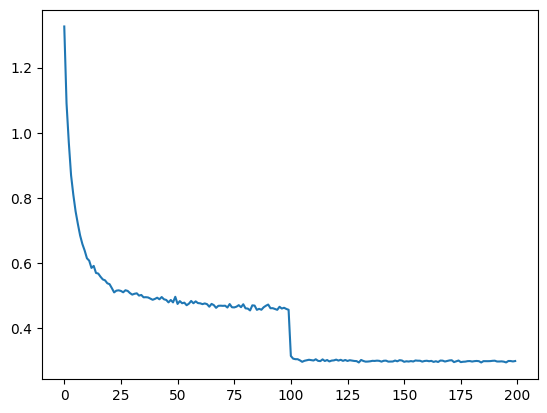

In [10]:
# plotting average logged loss every 500 data points 
plt.plot(torch.tensor(step_loss).view(-1, 500).mean(1))

In [42]:
# calculate losses on the splits
def get_loss(split):
    if split == 'train':
        X_split, Y_split = X_train, Y_train 
    else:
        X_split, Y_split = X_val, Y_val
    x = C[X_split].view(-1, m * block_size)           
    hidden_layer = torch.tanh(x @ H + d)
    logits = x @ W + hidden_layer @ U + b    
    loss = F.cross_entropy(logits, Y_split)
    return loss.item()

l = get_loss('train')
print(f'train_loss = {l}')
l = get_loss('val')
print(f'val_loss = {l}')

train_loss = 1.94937002658844
val_loss = 2.082943916320801


I decided to test the two models with the lowest loss without direct connection.<br><br>
v = 68 (vocab size)
| block_size | m (dims) | h (n_hidden) | learning_rate* | n_iter | batch_size |  p_train_loss | train_loss | p_val_loss | val_loss | p_total_params | total_params |
|:---:|:---:|:---:|:--------:|:---:|:---:|:--------:|:--------:|:--------:|:--------:|:---:|:---:|
| 3 | 20 | 100 | 0.1 / 0.01 | 100000 | 32 | 1.986456 | 1.985039 | 2.117931| 2.103702 | 14328 | 18408 |
| 3 | 50 | 100 | 0.1 / 0.01 | 100000 | 32 | 1.976877 | 1.952201 | 2.115579| 2.090269 | 25368 | 35568 |

*equal amounts of iterations per learning rate<br><br>
Adding direct connection improved model's performance. It's interesting that the bigger model got bigger improvement. Let's test this on previous, even bigger models that had higher loss.
| block_size | m (dims) | h (n_hidden) | learning_rate* | n_iter | batch_size |  p_train_loss | train_loss | p_val_loss | val_loss | p_total_params | total_params |
|:---:|:---:|:---:|:--------:|:---:|:---:|:--------:|:--------:|:--------:|:--------:|:---:|:---:|
| 12 | 50 | 400 | 0.1 / 0.01 | 100000 | 64 | 2.182727 | 2.001002 | 2.336708 | 2.154892 | 271068 | 311868 |
| 12 | 75 | 400 | 0.1 / 0.01 | 100000 | 64 | 2.190321 | 2.003366 | 2.337827 | 2.171011 | 271068 | 453968 |

Direct connection helped a lot more with bigger model's performance.

In [41]:
# sample from the model
g =torch.Generator().manual_seed(42)

for _ in range(20):
    out = []
    context = [0] * block_size                                        
    while True:
        x = C[torch.tensor([context])].view(-1, m * block_size)                            
        hidden_layer = torch.tanh(x @ H + d)       
        logits = x @ W + hidden_layer @ U + b
        probs = F.softmax(logits, dim=1)
        index = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [index]
        out.append(index)
        if index == 0:
            break
    
    print(''.join(itos[i] for i in out))

MAKAVICHNIK.
CZEWSKI.
CHAMO.
KULA.
ZAPIETSKYI.
FOŁOWIATOSIKOWSKI.
LOZOK.
PEDOROSZEWSKI.
TASZEMAŃDOSZEWICZYŃSKI.
SZLAASKUBCZYK.
MASZKA.
TABASIA.
SZRZACZKOWSKI.
WEROWIADELIŃSKI.
BOŁOWICZ.
WADEMBOGODZIUBE.
ZIBIESZKA.
ZON.
GREJEWSKI.
PISAŁA.


Samples from the best model:
<ol>
    <li>MAKAVICHOWSKI.</li>
    <li>BILIPACHAMO.</li>
    <li>KULA.</li>
    <li>STARA.</li>
    <li>SZYN.</li>
    <li>KOCZACHANDRENDROWICKI.</li>
    <li>KURPOV.</li>
    <li>BRZEWSKI.</li>
    <li>TYMARGAŃDOSAJERSKI.</li>
    <li>RADOS.</li>
    <li>LAASKA.</li>
    <li>HAŁĄDŹ.</li>
    <li>SZKO.</li>
    <li>TABASIA.</li>
    <li>SZLADCZKA.</li>
    <li>STELINIAK.</li>
    <li>PIETKOWSKI.</li>
    <li>WOJTOSI.</li>
    <li>MADEMBOGUDZIKIEWICZ.</li>
    <li>WÓLKA.</li>
</ol>

#### Model improvements

##### I implemented those "features" to try and see what's the best result I can get from this architecture.
<ol>
    <li>Paramters initialization adjustment</li>
    <li>Layer Norm / Batch Norm</li>
<ol>
<br>
Model that I tested on:

| block_size | m (dims) | h (n_hidden) | learning_rate* | n_iter | batch_size | total_params |
|:---:|:---:|:---:|:--------:|:---:|:---:|:---:|
| 3 | 50 | 100 | 0.1 / 0.01 | 100000 | 32 | 35568 |

In [119]:
# hyperparameters
block_size = 3
m = 50  # number of dimenstions
h = 400 # number of hidden units
learning_rate = 0.1
n_iter = 100000
batch_size = 32
kaiming_init = 5/3 / (m * block_size)**0.5

In [115]:
X, Y = build_dataset(words, block_size)

print(X.shape, Y.shape)
for x,y in zip(X[:10], Y[:10]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

torch.Size([412553, 3]) torch.Size([412553])
... --> N
..N --> O
.NO --> W
NOW --> A
OWA --> K
WAK --> .
... --> K
..K --> O
.KO --> W
KOW --> A


In [116]:
# create random splits of data - 90% train set, 10% validation set
import random # for reproducibility
random.seed(42)
random.shuffle(words)

n = int(0.9 * Y.shape[0])
X_train, X_val = X[:n], X[n:]
Y_train, Y_val = Y[:n], Y[n:]

In [120]:
# parameters
g = torch.Generator().manual_seed(42) # for reproducibility

C = torch.randn((v, m), generator=g)
H = torch.randn((m * block_size, h), generator=g) * kaiming_init
# d = torch.randn(h, generator=g) * 0.01 for normalization
U = torch.randn((h, v), generator=g) * 0.01
b = torch.randn(v, generator=g) * 0.01
W = torch.randn((m * block_size, v), generator=g) * 0.01

# batch norm
bn_gain = torch.ones((1, h))
bn_bias = torch.zeros((1, h))
bn_mean_running = torch.zeros((1, h))
bn_std_running = torch.ones((1, h))

# layer norm
ln_gain = torch.ones((1, h))
ln_bias = torch.zeros((1, h))

parameters = [C, H, U, b, W, ln_gain, ln_bias] # without d for normalization
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True  

101668


In [121]:
def batch_norm_train(batch, bn_gain, bn_bias, bn_mean_running, bn_std_running):
    bn_mean_per_i = batch.mean(0, keepdim=True)
    bn_std_per_i = batch.std(0, keepdim=True)
    batch = bn_gain * (batch - bn_mean_per_i) / bn_std_per_i + bn_bias
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_per_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_per_i
    return batch

def batch_norm_test(batch, bn_gain, bn_bias, bn_mean_running, bn_std_running):
    batch = bn_gain * (batch - bn_mean_running) / bn_std_running + bn_bias
    return batch
    
def layer_norm(batch, ln_gain, ln_bias):
    ln_mean = batch.mean(1, keepdim=True)
    ln_std = batch.std(1, keepdim=True)
    batch = ln_gain * (batch - ln_mean) / ln_std + ln_bias
    return batch

In [122]:
steps = []
step_loss = []

for iter in range(n_iter):
   # getting minibatch
    index = torch.randint(0, X_train.shape[0], (batch_size,)) 

    # forward pass
    x = C[X_train[index]].view(-1, m * block_size)
    hidden_layer_pre_act = x @ H #+ d for normalization
    hidden_layer_pre_act = layer_norm(hidden_layer_pre_act, ln_gain, ln_bias)
    hidden_layer = torch.tanh(hidden_layer_pre_act)
    logits = x @ W + hidden_layer @ U + b
    loss = F.cross_entropy(logits, Y_train[index])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # save data
    steps.append(iter)
    step_loss.append(loss.log10())

    learning_rate = 0.1 if iter < 50000 else 0.01
            
    # update    
    for p in parameters:
        p.data -= learning_rate * p.grad

    # print once in a while
    if (iter+1) % 1000 == 0:
        print(iter+1, loss.item())

1000 2.3360939025878906
2000 2.200416326522827
3000 2.2017853260040283
4000 2.1058740615844727
5000 1.4624714851379395
6000 2.204050064086914
7000 2.0182909965515137
8000 1.9094396829605103
9000 1.5615689754486084
10000 2.2528791427612305
11000 2.2849888801574707
12000 1.6254806518554688
13000 1.8006060123443604
14000 2.0475351810455322
15000 1.7053141593933105
16000 2.065634250640869
17000 2.0034921169281006
18000 1.8999561071395874
19000 1.9620786905288696
20000 2.075766086578369
21000 1.5213130712509155
22000 2.2733712196350098
23000 2.0292513370513916
24000 2.426924705505371
25000 1.892059564590454
26000 2.138340473175049
27000 1.7809332609176636
28000 1.7501946687698364
29000 1.5483355522155762
30000 2.227597236633301
31000 2.0102884769439697
32000 2.3238399028778076
33000 2.1897060871124268
34000 1.9558873176574707
35000 1.7652809619903564
36000 1.9575966596603394
37000 2.186335563659668
38000 2.124277114868164
39000 1.7528531551361084
40000 1.6824984550476074
41000 1.52755188941

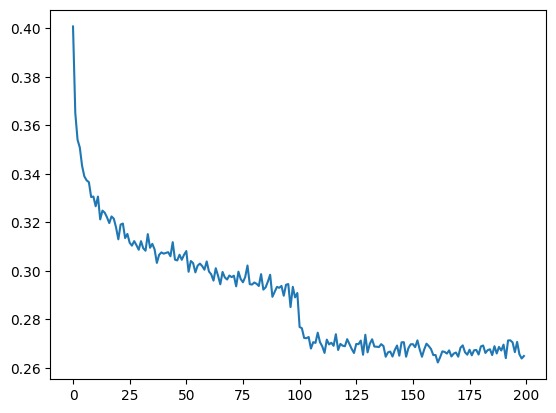

In [123]:
# plotting average logged loss every 500 data points 
plt.plot(torch.tensor(step_loss).view(-1, 500).mean(1))

In [124]:
# calculate losses on the splits
def get_loss(split):
    if split == 'train':
        X_split, Y_split = X_train, Y_train 
    else:
        X_split, Y_split = X_val, Y_val
    x = C[X_split].view(-1, m * block_size)          
    hidden_layer_pre_act = x @ H #+ d for normalization
    hidden_layer_pre_act = layer_norm(hidden_layer_pre_act, ln_gain, ln_bias)
    hidden_layer = torch.tanh(hidden_layer_pre_act)
    logits = x @ W + hidden_layer @ U + b
    loss = F.cross_entropy(logits, Y_split)
    return loss.item()

l = get_loss('train')
print(f'train_loss = {l}')
l = get_loss('val')
print(f'val_loss = {l}')

train_loss = 1.8632705211639404
val_loss = 1.9982855319976807


#### Results
v = 68 (vocab size)
| block_size | m (dims) | h (n_hidden) | learning_rate* | n_iter | batch_size | train_loss | val_loss | params | param init | norm
|:---:|:---:|:---:|:--------:|:---:|:---:|:--------:|:--------:|:---:|:---:|:---:|
| 3 | 50 | 100 | 0.1 / 0.01 | 100000 | 32 | 1.952201 | 2.090269 | 35568 | none | none |
| 3 | 50 | 100 | 0.1 / 0.01 | 100000 | 32 | 1.873789 | 2.007544 | 35568 | present | none |
| 3 | 50 | 100 | 0.1 / 0.01 | 100000 | 32 | 2.069724 | 2.205111 | 35668 | present | batch |
| 3 | 50 | 100 | 0.1 / 0.01 | 100000 | 64 | 2.145705 | 2.278057 | 35668 | present | batch |
| 3 | 50 | 100 | 0.1 / 0.01 | 100000 | 128 | 2.257887 | 2.391355 | 35668 | present | batch |
| 3 | 50 | 100 | 0.1 / 0.01 | 100000 | 32 | 1.892221 | 2.018405 | 35668 | present | layer |
| 3 | 50 | 200 | 0.1 / 0.01 | 100000 | 32 | 1.873022 | 2.004731 | 57668 | present | layer |
| 3 | 50 | 400 | 0.1 / 0.01 | 100000 | 32 | 1.863271 | 1.998286 | 101668 | present | layer |

*equal amounts of iterations per learning rate


In [125]:
# sample from the model
g =torch.Generator().manual_seed(42)

for _ in range(20):
    out = []
    context = [0] * block_size                                        
    while True:
        x = C[torch.tensor([context])].view(-1, m * block_size)
        hidden_layer_pre_act = x @ H #+ d for normalization
        hidden_layer_pre_act = layer_norm(hidden_layer_pre_act, ln_gain, ln_bias)                   
        hidden_layer = torch.tanh(hidden_layer_pre_act)       
        logits = x @ W + hidden_layer @ U + b
        probs = F.softmax(logits, dim=1)
        index = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [index]
        out.append(index)
        if index == 0:
            break
    
    print(''.join(itos[i] for i in out))

MAKAVICHOWSKI.
BILIPACHAMY.
KLEJ.
STARA.
SZYN.
KOCKI.
RADZIEDA.
WIDLAK.
KURTOWSKI.
RYCH.
DYSZ.
BRAŃCZAK.
WASIYK.
LIŃSKI.
ANDERCZEK.
MASZKO.
TABASIA.
SLYMACZKA.
WASZEWICZ.
PER.


Samples from the best model:
<ol>
    <li>MAKAVICHOWSKI.</li>
    <li>BILIPACHAMY.</li>
    <li>KLEJ.</li>
    <li>STARA.</li>
    <li>SZYN.</li>
    <li>KOCKI.</li>
    <li>RADZIEDA.</li>
    <li>WIDLAK.</li>
    <li>KURTOWSKI.</li>
    <li>RYCH.</li>
    <li>DYSZ.</li>
    <li>BRAŃCZAK.</li>
    <li>WASIYK.</li>
    <li>LIŃSKI.</li>
    <li>ANDERCZEK.</li>
    <li>MASZKO.</li>
    <li>TABASIA.</li>
    <li>SLYMACZKA.</li>
    <li>WASZEWICZ.</li>
    <li>PER.</li>
</ol>